# Install and load the libraries

In [1]:
!pip install -q sentence-transformers
!pip install -q wikipedia-api
!pip install -q numpy
!pip install -q scipy
!pip install rich
!pip install pypdf2

In [4]:
import re
import os
from rich import print
from sentence_transformers import SentenceTransformer
import numpy as np
import textwrap
from IPython.display import display, HTML

# load data

In [6]:
from wikipediaapi import Wikipedia
wiki = Wikipedia('RAGBot/0.0', 'en')
data = wiki.page('Satoru Gojo').text

## After Uploading a pdf
# data = load_document("/content/R_Tamil_LLama.pdf")

print(data)

Satoru Gojo (Japanese: 五条 悟, Hepburn: Gojō Satoru) is a character from Gege Akutami's manga Jujutsu Kaisen. He 
was first introduced in Akutami's short series Tokyo Metropolitan Curse Technical School as the mentor of the 
cursed teenager Yuta Okkotsu at Tokyo Prefectural Jujutsu High School. This miniseries became the prequel Jujutsu 
Kaisen 0 of Jujutsu Kaisen. In Jujutsu Kaisen, Gojo takes the same role but mentors the student Yuji Itadori who 
suffers a similar Curse, helping him become stronger while protecting other characters in the series.
Gojo was designed by Akutami to be a formidable yet endearing figure who is passionate about his students. He is 
voiced by Yūichi Nakamura in Japanese and Kaiji Tang in English in the animated adaptations by MAPPA.
The character was well-received by the media for his carefree nature and power shown when protecting his students, 
becoming the series's breakout character. Furthermore, his role in the prequel Jujutsu Kaisen 0 was appreciated by 
the media due to his hidden traits, such as his relationship with the antagonist Suguru Geto.

Creation and conception
Gege Akutami intended for Gojo to be one of the strongest characters in the entire series, but at the same time 
easy to understand to readers. One of Gojo's key ideas for his design is a blindfold he can see through thanks to 
his supernatural powers. His bright-blue eyes endowed to him from birth, the Six Eyes, bear extrasensory powers, 
granting him the heightened ability to see, read, and manipulate Cursed energy, as well as amplify his own 
technique, Limitless. In his debut in Jujutsu Kaisen 0, Akutami linked Gojo and Yuta Okkotsu to Michizane Sugawara,
a famous figure in Japanese history, which he described as the source of both characters' supernatural powers. This
was done as a tribute to his late editor, Yamanaka. Gojo's design is intended to be one of a handsome man, often 
called bishonen. His facial design was inspired by a major Naruto character whose face was covered in bandages. In 
regards to Gojo's relationship with his students, most notably Yuji Itadori and Yuta Okkotsu, Akutami wrote their 
relationship simply, as he claims Gojo only wants troublemakers like them to become strong. Despite the common 
Japanese custom of calling others by their last names, Gojo refers to each of his students by their first names. 
Akutami said he made this decision because he thought that Gojo did not have proper considerations for such social 
traditions.
Sunghoo Park, who directed the first season of the series' anime adaptation as well as the new prequel movie, said 
adapting one of Gojo's early scenes involving the Domain Expansion scene in the season was particularly tough to 
get just right. Nevertheless, he saw the sequence as memorable. Since the original scene was black-and-white, Park 
and his team consulted Akutami for guidance on color design from Gojo's Domain Expansion. In regards to the 
animated movie, Park stated that, while "the highlight of the movie is of course, the story of Okkotsu and Rika as 
the main characters of Jujutsu Kaisen 0", he also wanted to focus on more characters from the manga, most notably 
of which being the past relationship between Gojo and Geto, which was explored briefly in the original manga. Seko 
was requested by the director to feature a new fight scene between Gojo and Miguel in the climax.
The song "Where Our Blue Is" by Tatsuya Kitani, which acts as the opening of the anime's second season, deals with 
the youth of Gojo and Geto with an emphasis on blue backgrounds. The opening contrasts the ending theme "Light", 
which uses a more relaxed melody while emphasizing Gojo and Geto's friendship.

Casting
Yuichi Nakamura voices the character Satoru Gojo in the original Japanese series. From serious scenes to comical 
gag scenes, Gojo has different facial expressions, but since he played without restrictions on the swing range 
between on and off, Nakamura reiterated at the recordi

# Chunking the data

In [8]:
def chunk_text(text, chunk_size=1000, overlap=20):
    """
    Split the text into chunks based on the number of words and word overlap.
    """
    words = text.split()
    chunks = []
    for i in range(0, len(words), chunk_size - overlap):
        chunk = ' '.join(words[i:i + chunk_size])
        chunks.append(chunk)
    return chunks

chunked_data = chunk_text(data)

print("Total number of chunks", len(chunked_data))

Total number of chunks 3

# visualize chunking

In [10]:
def print_chunks(chunks):
    """
    Display text chunks in a clean, readable format using HTML styling.

    Args:
        chunks (list): List of text chunks to display
    """
    # Create the HTML for the chunks display
    html_content = """
    <style>
        .chunk-container {
            font-family: Arial, sans-serif;
            margin: 20px 0;
        }
        .chunk-header {
            background-color: #f0f2f6;
            padding: 5px 10px;
            border-radius: 5px 5px 0 0;
            border-left: 4px solid #3498db;
            font-weight: bold;
            color: #2c3e50;
        }
        .chunk-content {
            background-color: #ffffff;
            color: #2c3e50;
            padding: 10px;
            border: 1px solid #e1e4e8;
            border-left: 4px solid #3498db;
            border-top: none;
            border-radius: 0 0 5px 5px;
            white-space: pre-wrap;
            font-family: monospace;
        }
    </style>
    """

    # Add each chunk to the HTML content
    for i, chunk in enumerate(chunks, 1):
        # Wrap text for better readability
        wrapped_text = textwrap.fill(chunk, width=100)

        html_content += f"""
        <div class="chunk-container">
            <div class="chunk-header">Chunk {i}</div>
            <div class="chunk-content">{wrapped_text}</div>
        </div>
        """

    # Display the HTML
    display(HTML(html_content))
print_chunks(chunked_data)

# Setting up embedding model

In [12]:
# Load the sentence transformer model for embeddings

model = SentenceTransformer("Alibaba-NLP/gte-base-en-v1.5", trust_remote_code=True)
# model = SentenceTransformer("BAAI/bge-small-en-v1.5", trust_remote_code=True)
# model = SentenceTransformer("all-MiniLM-L6-v2", trust_remote_code=True)

# understanding Cosine Similarity 

In [14]:
def cosine_similarity(vector_a, vector_b):
    """
    Calculate the cosine similarity between two vectors.
    Cosine similarity measures how similar two vectors are by calculating the cosine of the angle between them.

    Args:
        vector_a: First vector (numpy array)
        vector_b: Second vector (numpy array)

    Returns:
        float: Similarity score between -1 and 1
               1: Vectors are identical
               0: Vectors are perpendicular
              -1: Vectors are opposite
    """
    # Step 1: Calculate the dot product between the vectors
    # Dot product measures how much vectors point in the same direction
    dot_product = np.dot(vector_a, vector_b)

    # Step 2: Calculate the magnitude (length) of each vector
    # Magnitude is the square root of the sum of squared values
    magnitude_a = np.linalg.norm(vector_a)  # √(a1² + a2² + ... + an²)
    magnitude_b = np.linalg.norm(vector_b)  # √(b1² + b2² + ... + bn²)

    # Step 3: Calculate the cosine similarity
    # Divide dot product by the product of magnitudes
    similarity = dot_product / (magnitude_a * magnitude_b)

    return similarity

# similarity understanding

In [17]:
sentence1 = "The cat sat on the mat"
sentence2 = "A cat is sitting on a mat"

In [19]:
def get_similarity_score(sentence1, sentence2):
    """
    Calculate similarity score between two sentences.

    Args:
        sentence1 (str): First sentence
        sentence2 (str): Second sentence

    Returns:
        float: Similarity score between 0 and 1
    """
    # Get embeddings
    embedding1 = model.encode(sentence1, normalize_embeddings=True)
    embedding2 = model.encode(sentence2, normalize_embeddings=True)

    # Calculate similarity
    similarity = cosine_similarity(embedding1, embedding2)

    return similarity

# change the sentences


score = get_similarity_score(sentence1, sentence2)
print(f"Similarity score: {score:.4f}")

Similarity score: 0.9067

# visualize

Similarity Score: 0.9067

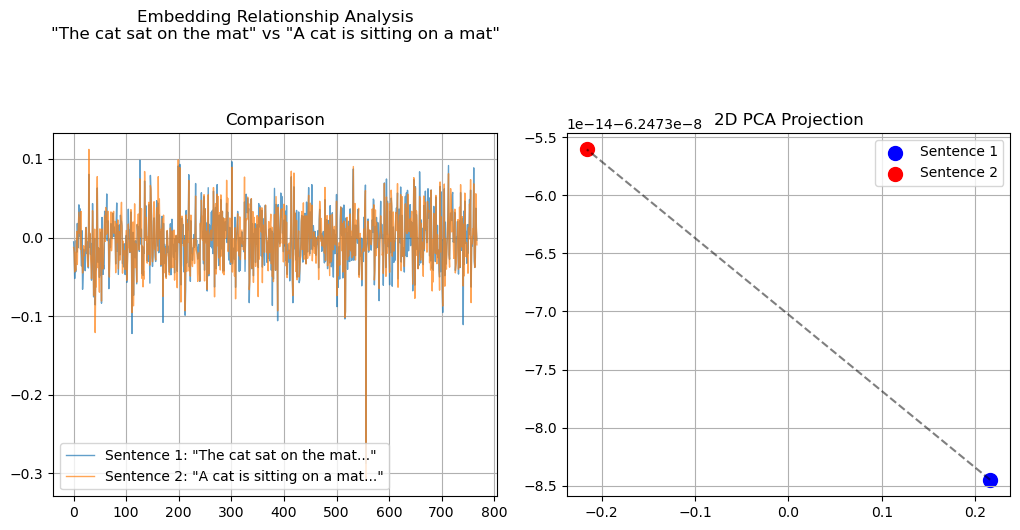

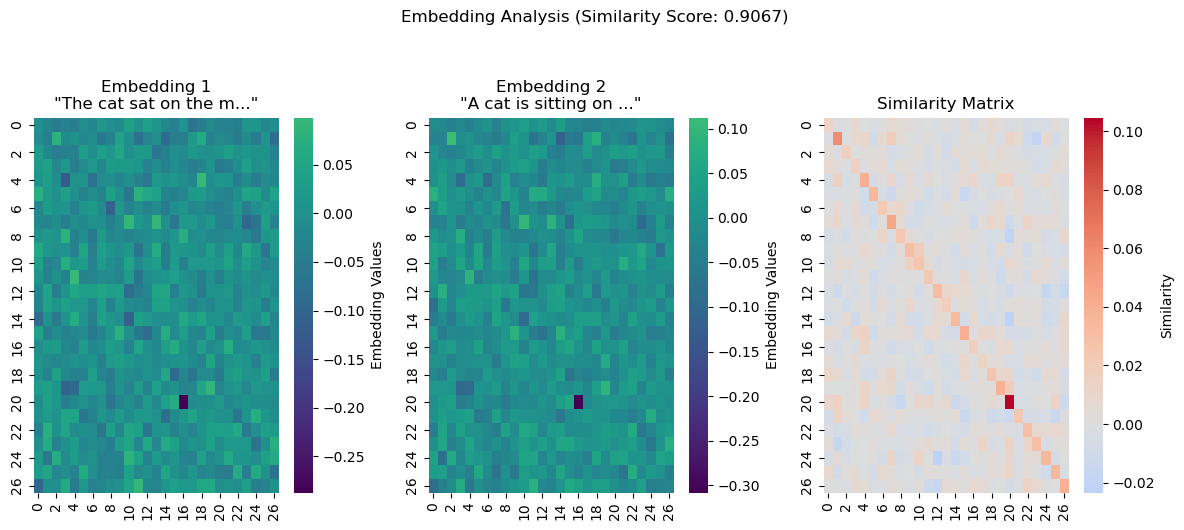

0.90672326

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

def visualize_embeddings(sentence1, sentence2):
    """
    Visualize the relationship between two sentence embeddings using
    multiple visualization techniques.

    Args:
        sentence1 (str): First sentence
        sentence2 (str): Second sentence
    """
    # Get embeddings
    embedding1 = model.encode(sentence1, normalize_embeddings=True)
    embedding2 = model.encode(sentence2, normalize_embeddings=True)
    dimensions = range(len(embedding1))

    # Create figure with subplots
    fig = plt.figure(figsize=(15, 5))


    # Dimension-wise Comparison
    plt.subplot(132)
    plt.plot(dimensions, embedding1,
             label=f'Sentence 1: "{sentence1[:30]}..."',
             alpha=0.7,
             linewidth=1)
    plt.plot(dimensions, embedding2,
             label=f'Sentence 2: "{sentence2[:30]}..."',
             alpha=0.7,
             linewidth=1)
    plt.title('Comparison')
    plt.legend()
    plt.grid(True)

    # 2D PCA Projection
    plt.subplot(133)
    # Combine embeddings and apply PCA
    combined_embeddings = np.vstack([embedding1, embedding2])
    pca = PCA(n_components=2)
    projected = pca.fit_transform(combined_embeddings)

    plt.scatter(projected[0, 0], projected[0, 1], c='blue', label='Sentence 1', s=100)
    plt.scatter(projected[1, 0], projected[1, 1], c='red', label='Sentence 2', s=100)
    plt.plot([projected[0, 0], projected[1, 0]],
             [projected[0, 1], projected[1, 1]],
             'k--', alpha=0.5)
    plt.title('2D PCA Projection')
    plt.legend()
    plt.grid(True)

    # Add overall title and adjust layout
    plt.suptitle(f'Embedding Relationship Analysis\n"{sentence1}" vs "{sentence2}"',
                 fontsize=12, y=1.05)
    plt.tight_layout()

    # Calculate and display similarity score
    similarity = np.dot(embedding1, embedding2)
    print(f"Similarity Score: {similarity:.4f}")

    plt.show()

def plot_embedding_heatmap(sentence1, sentence2):
    """
    Create an improved heatmap visualization of embedding similarities.

    Args:
        sentence1 (str): First sentence
        sentence2 (str): Second sentence
    """
    # Get embeddings
    embedding1 = model.encode(sentence1, normalize_embeddings=True)
    embedding2 = model.encode(sentence2, normalize_embeddings=True)

    # Reshape embeddings to 2D matrices for better visualization
    size = int(np.sqrt(len(embedding1)))
    matrix1 = embedding1[:size*size].reshape(size, size)
    matrix2 = embedding2[:size*size].reshape(size, size)

    # Create similarity matrix
    similarity_matrix = np.dot(matrix1, matrix2.T)

    # Plot setup
    plt.figure(figsize=(12, 5))

    # Create subplots for both individual embeddings and their similarity
    plt.subplot(131)
    sns.heatmap(matrix1,
                cmap='viridis',
                center=0,
                cbar_kws={'label': 'Embedding Values'})
    plt.title(f'Embedding 1\n"{sentence1[:20]}..."')

    plt.subplot(132)
    sns.heatmap(matrix2,
                cmap='viridis',
                center=0,
                cbar_kws={'label': 'Embedding Values'})
    plt.title(f'Embedding 2\n"{sentence2[:20]}..."')

    plt.subplot(133)
    sns.heatmap(similarity_matrix,
                cmap='coolwarm',
                center=0,
                cbar_kws={'label': 'Similarity'})
    plt.title('Similarity Matrix')

    # Calculate overall similarity score
    similarity = np.dot(embedding1, embedding2)

    # Add overall title with similarity score
    plt.suptitle(f'Embedding Analysis (Similarity Score: {similarity:.4f})',
                 y=1.05)

    plt.tight_layout()
    plt.show()

    return similarity

visualize_embeddings(sentence1, sentence2)
plot_embedding_heatmap(sentence1, sentence2)

# embed chunks

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

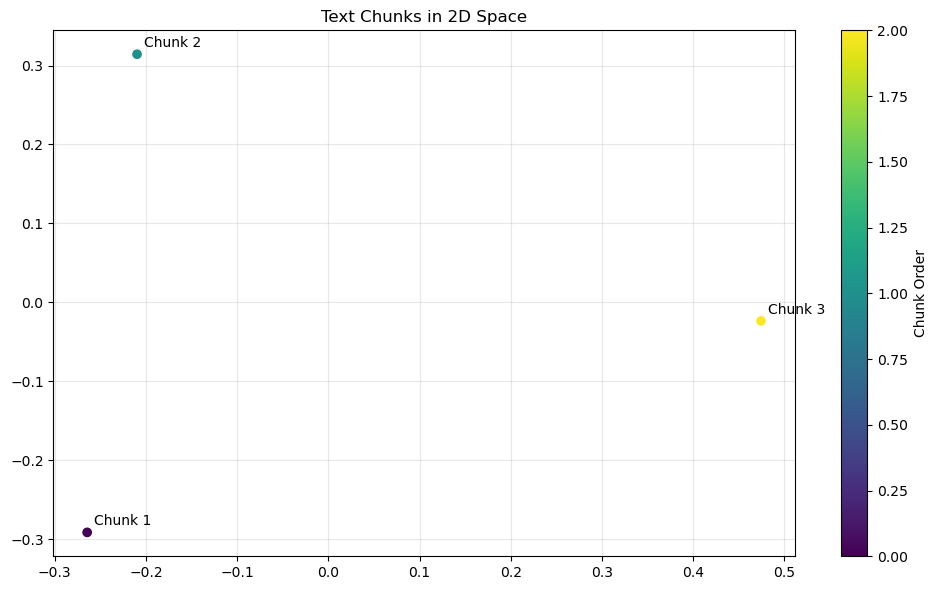

In [25]:
def simple_visualize_chunks(chunks):
    """
    Create a simple 2D visualization of text chunk relationships.

    Args:
        chunks (list): List of text chunks to visualize
    """
    # Get embeddings and reduce dimensions
    embeddings = model.encode(chunks, normalize_embeddings=True, show_progress_bar=True)
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(embeddings)

    # Create plot
    plt.figure(figsize=(10, 6))
    plt.scatter(reduced[:, 0], reduced[:, 1], c=range(len(chunks)), cmap='viridis')

    # Add labels
    for i, (x, y) in enumerate(reduced):
        plt.annotate(f"Chunk {i+1}", (x, y), xytext=(5, 5), textcoords='offset points')

    plt.title("Text Chunks in 2D Space")
    plt.grid(True, alpha=0.3)
    plt.colorbar(label='Chunk Order')

    plt.tight_layout()
    plt.show()

# Example usage:
# chunked_data = ["hello", "bird", "how are you doing" , "king"]
simple_visualize_chunks(chunked_data)